In [1]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher
from spacy.tokens import Span

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

In [2]:
candidate_sentences = pd.read_csv("output-2.csv")
candidate_sentences.shape

(7398, 1)

In [3]:
candidate_sentences['sentence'].sample(5)

1139    Film critic Mark Kermode , a noted detractor of 3D , has surmised that there is an emerging policy of distributors to limit the availability of 2D versions , thus " railroading " the 3D format int...
1829                                                                                                                              n " -gram models are widely used in statistical natural language processing .
3994    This is done by modeling the received signal then using a statistical estimation method such as maximum likelihood ( ML ) , majority voting ( MV ) or maximum a posteriori ( MAP ) to make a decisio...
338                                                                       Semantic networks are used in natural language processing applications such as semantic parsing Poon , Hoifung , and Pedro Domingos .
4298                                                                                               The introduction of kernel function provide additional flexibility to

Dependency parsing where we convert big text into small sentences, which contains only one sub and one obj.

subject-verb-object (SVO)

In [4]:
doc = nlp("Arun is coding the NER-project")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Arun ... nsubj
is ... aux
coding ... ROOT
the ... det
NER ... compound
- ... punct
project ... dobj


Entity Extraction

1) Initialisation
2) Iterate if not punct and if compound will keep in prefix
2.1) cuz compound(prefix) + word = new meaning
2.2) compund(modifier) + word(sub/obj) = new meaning
3)if tok is sub, reset. ent1 = sub
4)if tok is obj, token = ent2. Reset.
5)update tok and mod to prev

In [5]:
def get_entities(sent):
  # 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  for tok in nlp(sent):
    # 2
    if tok.dep_ != "punct":

      if tok.dep_ == "compound":
        prefix = tok.text

        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text


      if tok.dep_.endswith("mod") == True:
        modifier = tok.text

        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text

      # 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""

      # 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text

      # 5

      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text

  return [ent1.strip(), ent2.strip()]

In [6]:
get_entities("the film had 200 patents")

['film', '200  patents']

In [7]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 7398/7398 [01:18<00:00, 93.73it/s] 


In [8]:
entity_pairs[10:20]

[['soundtrack', 'original Golden score'],
 ['Screenwriter Hampton Fancher', 'Robert mind'],
 ['Roy Hauer', 'prior  filming'],
 ['she', 'Sammon'],
 ['92 Nina Axelrod', 'role'],
 ['combat Joanna Cassidy', 'Zhora'],
 ['Edward James Olmos', 'Gaff'],
 ['Director Martin Scorsese', 'it'],
 ['', 'Hampton Fancher'],
 ['', 'initially  Sammon']]

In [9]:
entity_pairs = []

for i in tqdm(candidate_sentences["sentence"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 7398/7398 [01:15<00:00, 98.48it/s] 


RE

rule based matching for main verb.

In [10]:
def get_relation(sent):

  doc = nlp(sent)

  matcher = Matcher(nlp.vocab)

  pattern = [{'DEP':'ROOT'},
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},
            {'POS':'ADJ','OP':"?"}]

  matcher.add("matching_1", [pattern])

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]]

  return(span.text)

In [11]:
get_relation("John completed the task")

'completed'

In [12]:
relations = [get_relation(i) for i in tqdm(candidate_sentences['sentence'])]

100%|██████████| 7398/7398 [01:20<00:00, 92.26it/s] 


In [13]:
pd.Series(relations).value_counts()[:50]

is              1341
was              204
are              142
used             135
include           80
used in           66
received          62
uses              60
has               43
developed         39
used for          38
announced         38
developed by      35
founded in        33
provides          30
won               29
in                27
called            27
were              26
use               25
have              24
published         24
based on          24
became            22
introduced        22
includes          22
used as           21
used by           21
been              21
made              21
awarded           20
included          20
released          20
took              19
presented         19
be                18
had               18
began             17
held              17
known for         16
considered        16
wrote             16
elected           16
applied to        16
founded           16
proposed          15
born in           15
describes    

KG


In [14]:
# extract subject
source = [i[0] for i in entity_pairs]

# extract object
target = [i[1] for i in entity_pairs]

kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations})

In [15]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47196 (\N{HANGUL SYLLABLE RO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48372 (\N{HANGUL SYLLABLE BO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


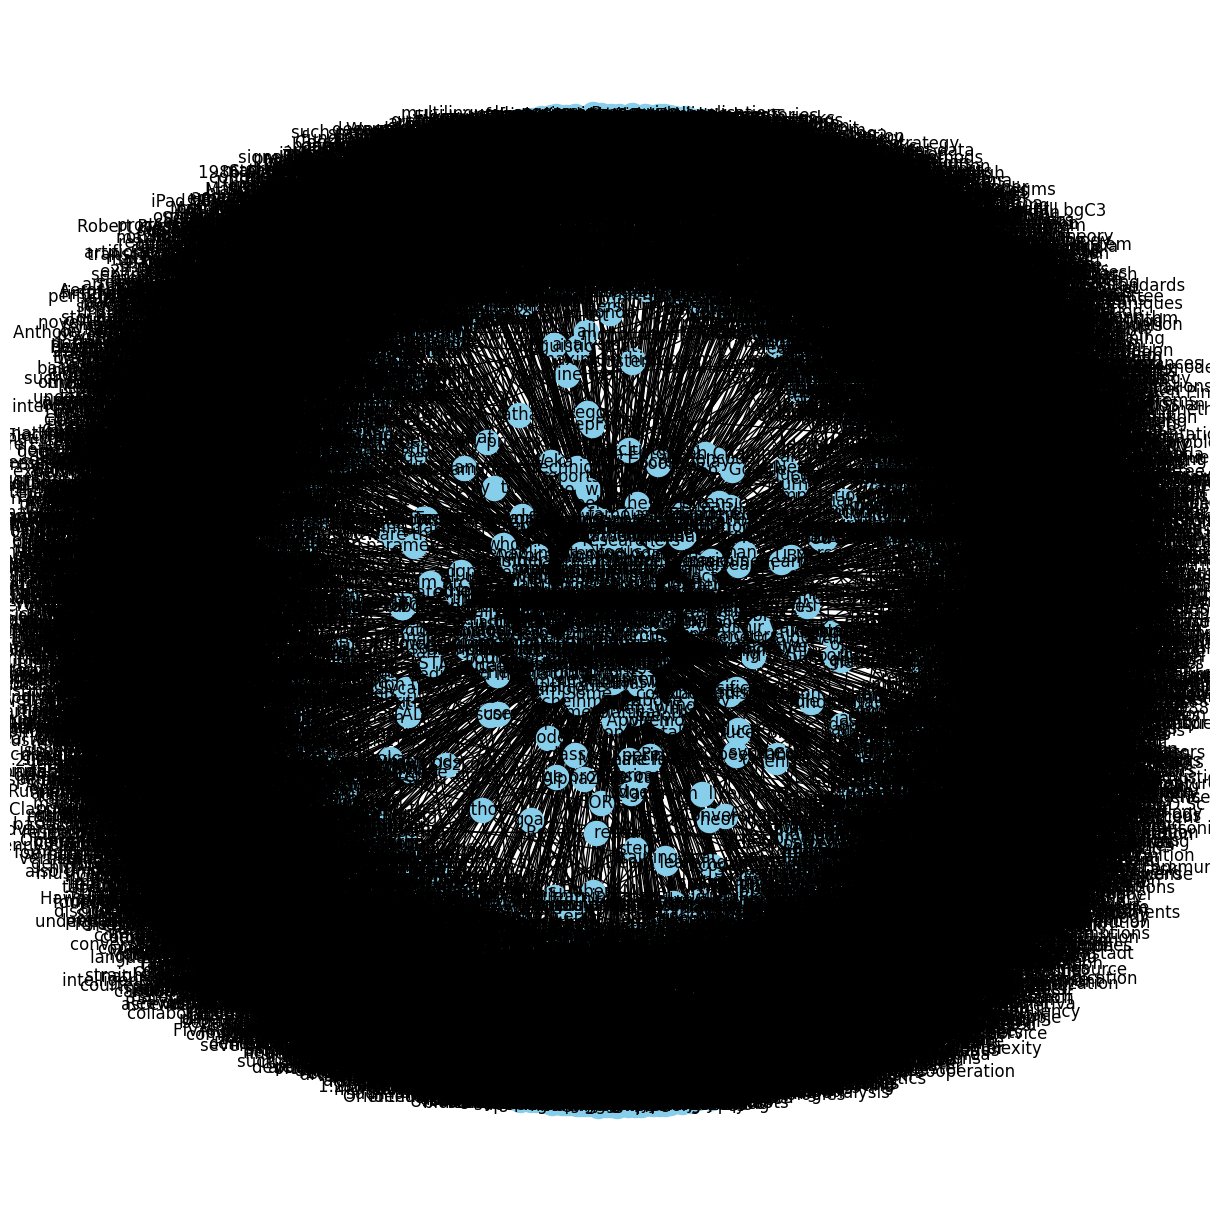

In [16]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

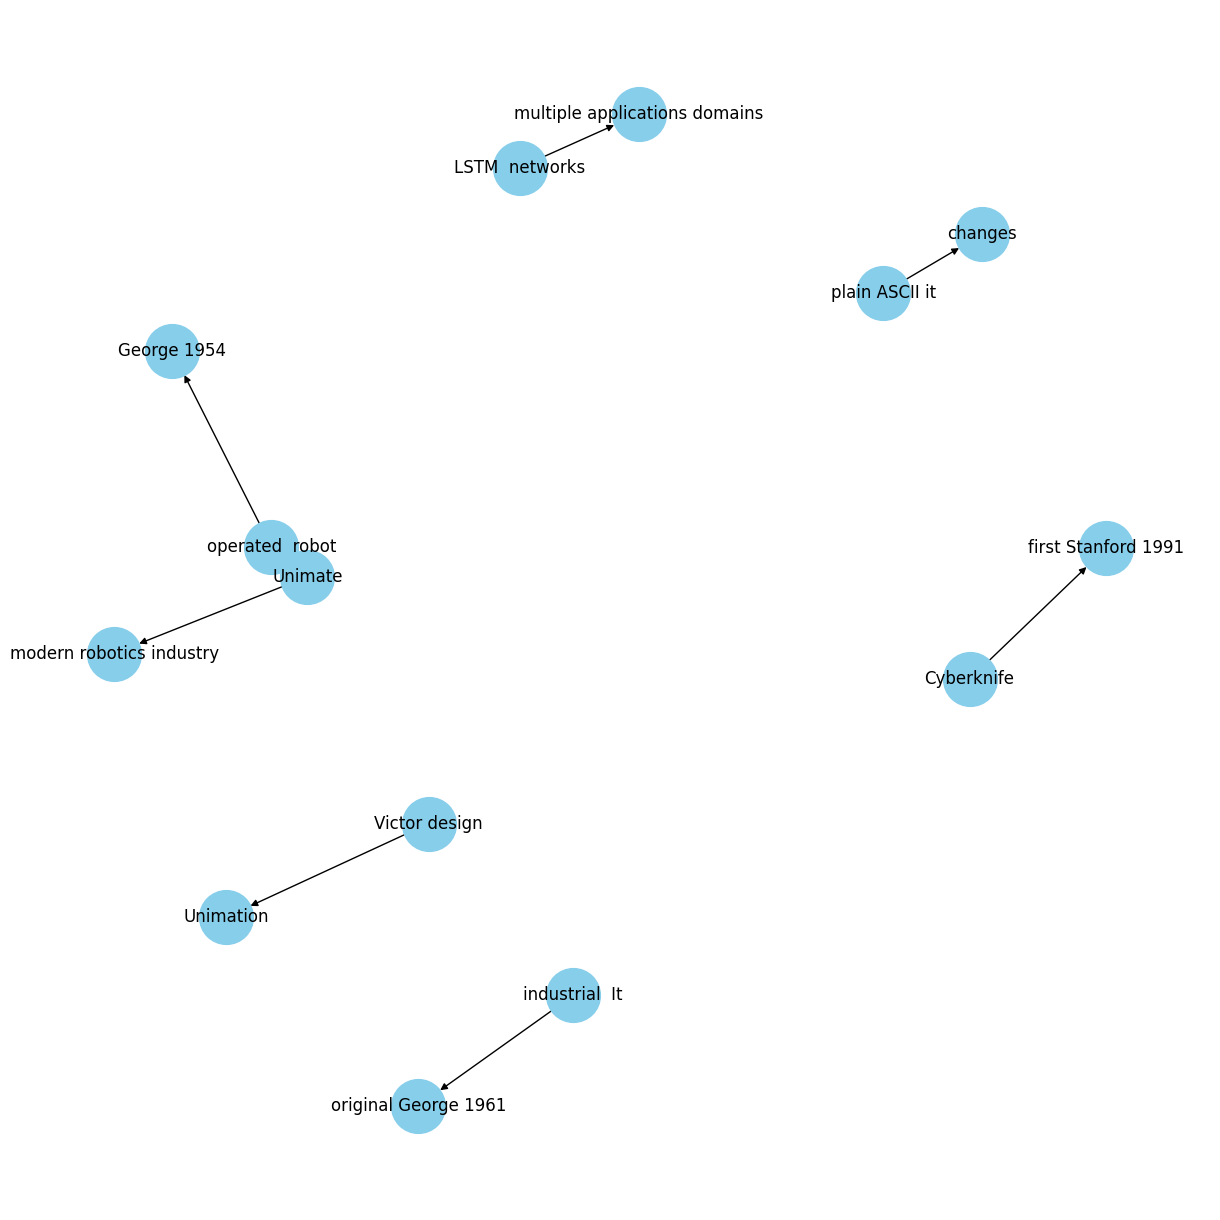

In [20]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="invented by"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5) # k regulates the distance between nodes
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

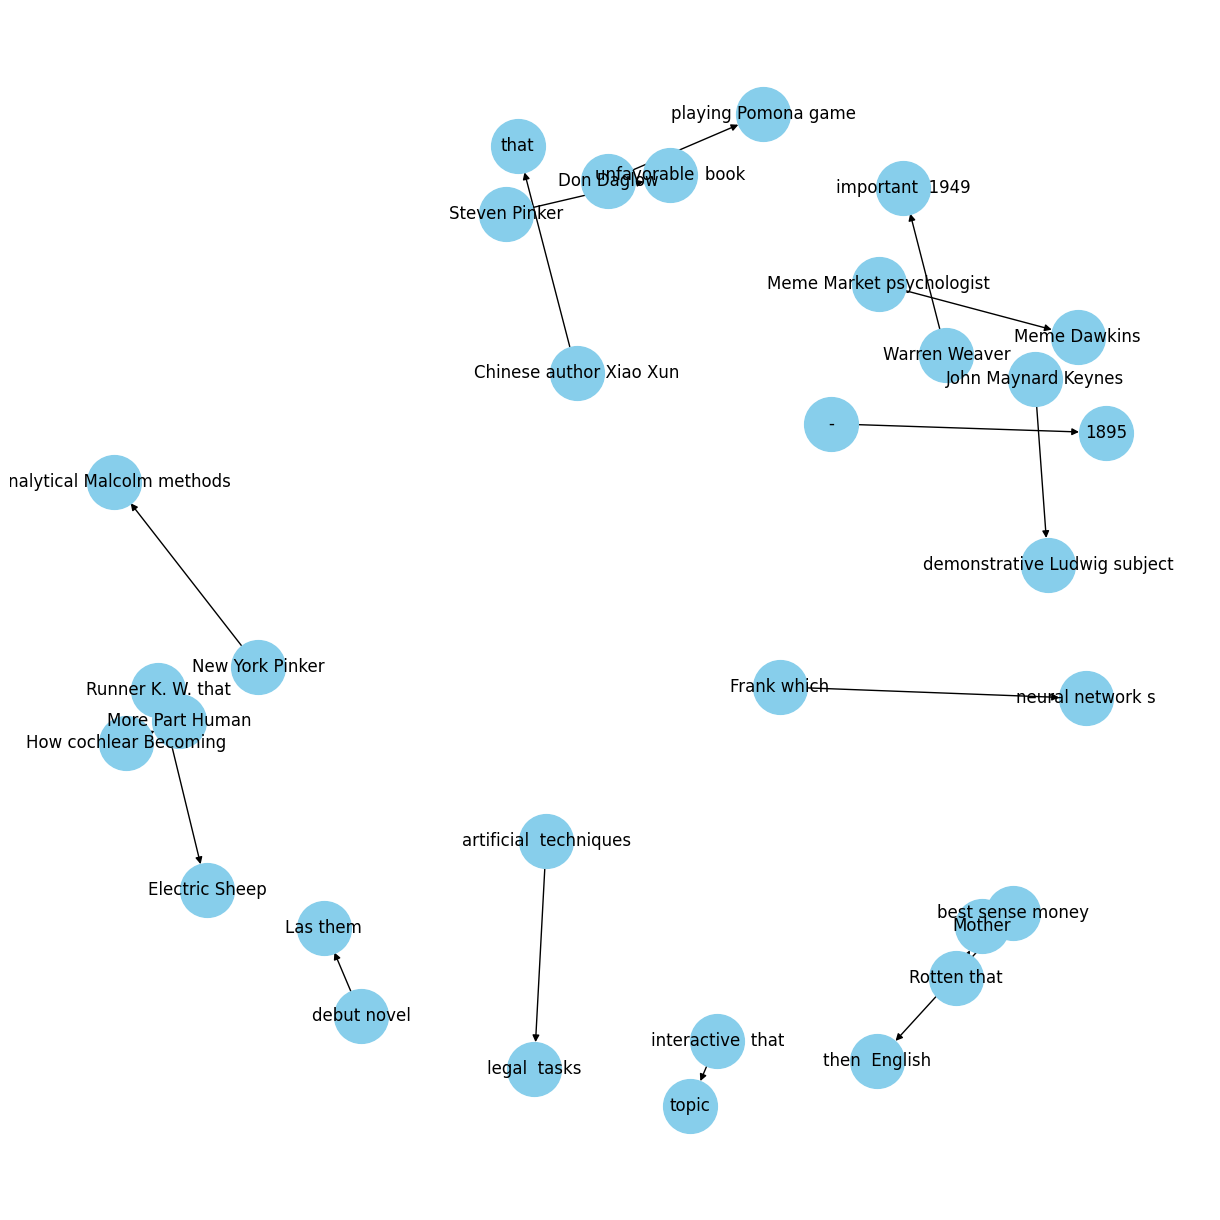

In [22]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="wrote"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()

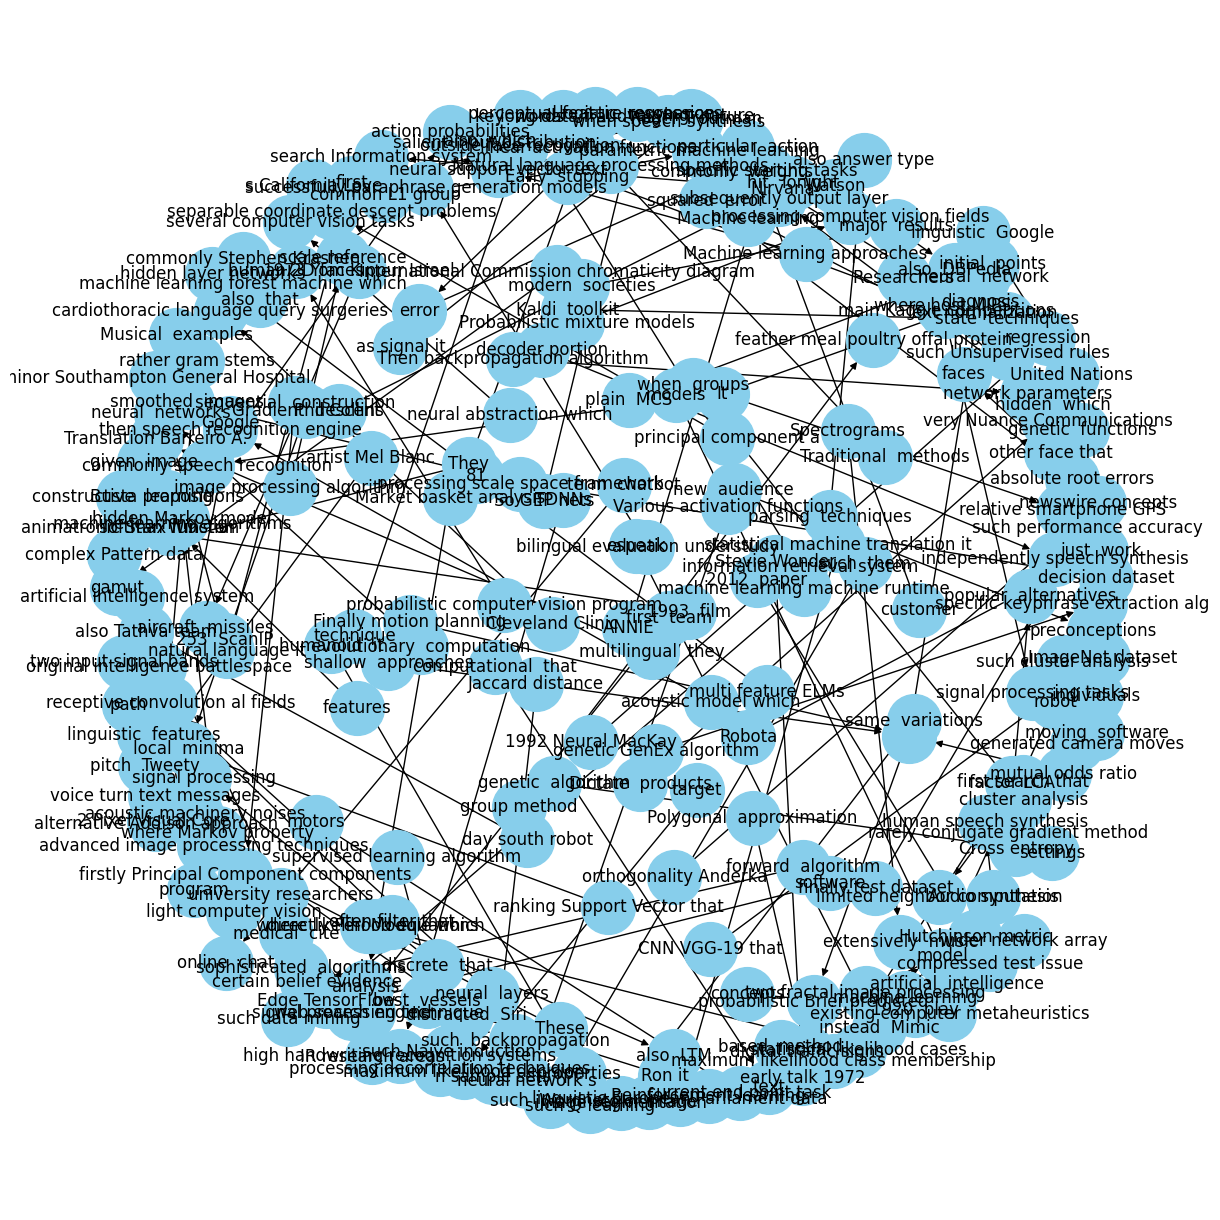

In [21]:
G=nx.from_pandas_edgelist(kg_df[kg_df['edge']=="used in"], "source", "target",
                          edge_attr=True, create_using=nx.MultiDiGraph())

plt.figure(figsize=(12,12))
pos = nx.spring_layout(G, k = 0.5)
nx.draw(G, with_labels=True, node_color='skyblue', node_size=1500, edge_cmap=plt.cm.Blues, pos = pos)
plt.show()